In [360]:
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import datetime as dt
from sklearn.model_selection import GridSearchCV

In [361]:
FILES_FOLDER = {
    "clean_data": [
        "clean_data/building.csv",
        "clean_data/meters.csv",
        "clean_data/weather.csv"
        #"data_for_data_challenge/X_test_data.csv", # The dataset test will be released one hour before the end of the Data Challenge
    ]
}


def load_data(folder, data_dir, dict_files=FILES_FOLDER):
    files = dict_files[folder]
    dataframes = []
    print(":: Start loading data")
    for name_file in tqdm(files):
        dataframe = pd.read_csv(os.path.join(data_dir, name_file))
        dataframes.append(dataframe)
    return dataframes


building, meters, weather = load_data("clean_data", "data_for_data_challenge/")

:: Start loading data


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


# Merge 

In [362]:
sorted_meters = meters.sort_values(by = 'timestamp')
sorted_weather = weather.sort_values(by = 'timestamp').drop(['Unnamed: 0','index'], axis = 1)
sorted_meters = sorted_meters[['timestamp','building_id','meter','meter_reading']]
sorted_meters = sorted_meters.join(building[['building_id','site_id','primary_use','sub_primary_use','square_feet']].set_index('building_id'), on = 'building_id')
sorted_to_merge = sorted_meters.copy()
merged_data = sorted_to_merge.merge(sorted_weather, how='inner', left_on=['timestamp', 'site_id'], right_on=['timestamp', 'site_id'])

In [363]:
merged_data

,timestamp,building_id,meter,meter_reading,site_id,primary_use,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,198,0,197.8700,2.0,Office,Office,163959.0,15.6,-5.6,1015.5,270.0,3.6
1,2016-01-01 00:00:00,239,3,67.4063,2.0,Lodging/residential,Dormitory,106440.0,15.6,-5.6,1015.5,270.0,3.6
2,2016-01-01 00:00:00,276,0,115.7400,2.0,Office,Office,70837.0,15.6,-5.6,1015.5,270.0,3.6
3,2016-01-01 00:00:00,234,0,63.0700,2.0,Education,College Classroom,179167.0,15.6,-5.6,1015.5,270.0,3.6
4,2016-01-01 00:00:00,191,0,54.8500,2.0,Education,College Classroom,78268.0,15.6,-5.6,1015.5,270.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,2017-06-30 23:00:00,46,0,35.4351,0.0,Retail,Retail,9045.0,25.6,22.8,1018.5,0.0,0.0
872590,2017-06-30 23:00:00,1031,3,5.0112,11.0,Education,Academic,93206.0,23.1,20.1,1008.0,180.0,3.6
872591,2017-06-30 23:00:00,658,0,0.0003,5.0,Entertainment/public assembly,Community Center,31075.0,14.0,12.0,NaN,310.0,3.1
872592,2017-06-30 23:00:00,739,0,0.0074,5.0,Education,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,310.0,3.1


In [364]:
merged_data.to_feather('merged_timestamp.feather')

# Date Feature Extraction

In [365]:
dt.datetime.strptime(merged_data.timestamp[58],"%Y-%m-%d %H:%M:%S").year

2016

In [366]:
def extract_years(str):
    return dt.datetime.strptime(str,"%Y-%m-%d %H:%M:%S").year
extract_years = np.vectorize(extract_years)

In [367]:
years = extract_years(merged_data.timestamp)

In [368]:
merged_data['YEAR'] =  years-min(years) 

In [369]:
def extract_day(str):
    return dt.datetime.strptime(str,"%Y-%m-%d %H:%M:%S").timetuple().tm_yday
extract_day = np.vectorize(extract_day)

In [370]:
days = extract_day(merged_data.timestamp)
days

array([  1,   1,   1, ..., 181, 181, 181])

In [371]:
merged_data['day'] =  days
merged_data['day']

0           1
1           1
2           1
3           1
4           1
         ... 
872589    181
872590    181
872591    181
872592    181
872593    181
Name: day, Length: 872594, dtype: int32

In [372]:
def extract_hour(str):
    return dt.datetime.strptime(str,"%Y-%m-%d %H:%M:%S").hour
extract_hour = np.vectorize(extract_hour)

In [373]:
hours = extract_hour(merged_data.timestamp)
hours

array([ 0,  0,  0, ..., 23, 23, 23])

In [374]:
merged_data['hour'] =  hours
merged_data['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [375]:
merged_data.drop(['timestamp','day'], axis = 1)

,building_id,meter,meter_reading,site_id,primary_use,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,YEAR,hour
0,198,0,197.8700,2.0,Office,Office,163959.0,15.6,-5.6,1015.5,270.0,3.6,0,0
1,239,3,67.4063,2.0,Lodging/residential,Dormitory,106440.0,15.6,-5.6,1015.5,270.0,3.6,0,0
2,276,0,115.7400,2.0,Office,Office,70837.0,15.6,-5.6,1015.5,270.0,3.6,0,0
3,234,0,63.0700,2.0,Education,College Classroom,179167.0,15.6,-5.6,1015.5,270.0,3.6,0,0
4,191,0,54.8500,2.0,Education,College Classroom,78268.0,15.6,-5.6,1015.5,270.0,3.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,46,0,35.4351,0.0,Retail,Retail,9045.0,25.6,22.8,1018.5,0.0,0.0,1,23
872590,1031,3,5.0112,11.0,Education,Academic,93206.0,23.1,20.1,1008.0,180.0,3.6,1,23
872591,658,0,0.0003,5.0,Entertainment/public assembly,Community Center,31075.0,14.0,12.0,NaN,310.0,3.1,1,23
872592,739,0,0.0074,5.0,Education,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,310.0,3.1,1,23


Jour ou nuit :

In [376]:
merged_data['Day/Night'] = merged_data['hour'].where((merged_data['hour']>=7) & (merged_data['hour']<=20),'Daylight')

In [377]:
merged_data['Day/Night'] = merged_data['Day/Night'].where((merged_data['Day/Night'] == 'Daylight'),'Night')

In [378]:
merged_data['Day/Night'].unique()

array(['Daylight', 'Night'], dtype=object)

In [379]:
merged_data = pd.concat([merged_data,pd.get_dummies(merged_data['Day/Night'])], axis = 1)

Week-end ou non :

In [380]:
merged_data = merged_data.drop(['Day/Night'], axis = 1)

In [381]:
def extract_weekday(str):
    return dt.datetime.strptime(str,"%Y-%m-%d %H:%M:%S").weekday()
extract_weekday = np.vectorize(extract_weekday)

In [382]:
merged_data['weekday']=extract_weekday(merged_data.timestamp)

In [383]:
merged_data['weekday'].unique()

array([4, 5, 6, 0, 1, 2, 3])

In [384]:
merged_data['weekday'] = merged_data['weekday'].where(merged_data['weekday']>=5,'week_in')

In [385]:
merged_data['weekday'] = merged_data['weekday'].where(merged_data['weekday']=='week_in','weekend')

In [386]:
merged_data = pd.concat([merged_data,pd.get_dummies(merged_data['weekday'])], axis = 1).drop(['weekday'], axis = 1)

In [387]:
merged_data

,timestamp,building_id,meter,meter_reading,site_id,primary_use,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,YEAR,day,hour,Daylight,Night,week_in,weekend
0,2016-01-01 00:00:00,198,0,197.8700,2.0,Office,Office,163959.0,15.6,-5.6,1015.5,270.0,3.6,0,1,0,1,0,1,0
1,2016-01-01 00:00:00,239,3,67.4063,2.0,Lodging/residential,Dormitory,106440.0,15.6,-5.6,1015.5,270.0,3.6,0,1,0,1,0,1,0
2,2016-01-01 00:00:00,276,0,115.7400,2.0,Office,Office,70837.0,15.6,-5.6,1015.5,270.0,3.6,0,1,0,1,0,1,0
3,2016-01-01 00:00:00,234,0,63.0700,2.0,Education,College Classroom,179167.0,15.6,-5.6,1015.5,270.0,3.6,0,1,0,1,0,1,0
4,2016-01-01 00:00:00,191,0,54.8500,2.0,Education,College Classroom,78268.0,15.6,-5.6,1015.5,270.0,3.6,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,2017-06-30 23:00:00,46,0,35.4351,0.0,Retail,Retail,9045.0,25.6,22.8,1018.5,0.0,0.0,1,181,23,1,0,1,0
872590,2017-06-30 23:00:00,1031,3,5.0112,11.0,Education,Academic,93206.0,23.1,20.1,1008.0,180.0,3.6,1,181,23,1,0,1,0
872591,2017-06-30 23:00:00,658,0,0.0003,5.0,Entertainment/public assembly,Community Center,31075.0,14.0,12.0,NaN,310.0,3.1,1,181,23,1,0,1,0
872592,2017-06-30 23:00:00,739,0,0.0074,5.0,Education,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,310.0,3.1,1,181,23,1,0,1,0


week end ou pas ? férié ? nuit ou jour, heures creuses ? tester différentes mailles temporelles, jour et nuit suffit ? Compléter les séries pour avoir les mêmes observations sur tous les building. Gap filling 
Random forest : créer classe "manquant" => précision moins bonne mais ok car pas de donnée. 

# Encoding of meter source

In [388]:
a = pd.get_dummies(merged_data['meter'])
a.columns = ['Meter 0','Meter 1','Meter 2','Meter 3']
merged_data = pd.concat([merged_data,a], axis = 1).drop(['meter'], axis = 1)

In [389]:
merged_data

,timestamp,building_id,meter_reading,site_id,primary_use,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,...,day,hour,Daylight,Night,week_in,weekend,Meter 0,Meter 1,Meter 2,Meter 3
0,2016-01-01 00:00:00,198,197.8700,2.0,Office,Office,163959.0,15.6,-5.6,1015.5,...,1,0,1,0,1,0,1,0,0,0
1,2016-01-01 00:00:00,239,67.4063,2.0,Lodging/residential,Dormitory,106440.0,15.6,-5.6,1015.5,...,1,0,1,0,1,0,0,0,0,1
2,2016-01-01 00:00:00,276,115.7400,2.0,Office,Office,70837.0,15.6,-5.6,1015.5,...,1,0,1,0,1,0,1,0,0,0
3,2016-01-01 00:00:00,234,63.0700,2.0,Education,College Classroom,179167.0,15.6,-5.6,1015.5,...,1,0,1,0,1,0,1,0,0,0
4,2016-01-01 00:00:00,191,54.8500,2.0,Education,College Classroom,78268.0,15.6,-5.6,1015.5,...,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,2017-06-30 23:00:00,46,35.4351,0.0,Retail,Retail,9045.0,25.6,22.8,1018.5,...,181,23,1,0,1,0,1,0,0,0
872590,2017-06-30 23:00:00,1031,5.0112,11.0,Education,Academic,93206.0,23.1,20.1,1008.0,...,181,23,1,0,1,0,0,0,0,1
872591,2017-06-30 23:00:00,658,0.0003,5.0,Entertainment/public assembly,Community Center,31075.0,14.0,12.0,NaN,...,181,23,1,0,1,0,1,0,0,0
872592,2017-06-30 23:00:00,739,0.0074,5.0,Education,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,...,181,23,1,0,1,0,1,0,0,0


# Encoding of sector

In [390]:
a = pd.get_dummies(merged_data['primary_use'])
label = merged_data['primary_use'].unique()
label.sort()
a.columns = label
merged_data = pd.concat([merged_data,a], axis = 1).drop(['primary_use'], axis = 1)

In [391]:
merged_data

,timestamp,building_id,meter_reading,site_id,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,...,Manufacturing/industrial,Office,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
0,2016-01-01 00:00:00,198,197.8700,2.0,Office,163959.0,15.6,-5.6,1015.5,270.0,...,0,1,0,0,0,0,0,0,0,0
1,2016-01-01 00:00:00,239,67.4063,2.0,Dormitory,106440.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-01 00:00:00,276,115.7400,2.0,Office,70837.0,15.6,-5.6,1015.5,270.0,...,0,1,0,0,0,0,0,0,0,0
3,2016-01-01 00:00:00,234,63.0700,2.0,College Classroom,179167.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-01 00:00:00,191,54.8500,2.0,College Classroom,78268.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,2017-06-30 23:00:00,46,35.4351,0.0,Retail,9045.0,25.6,22.8,1018.5,0.0,...,0,0,0,0,0,1,0,0,0,0
872590,2017-06-30 23:00:00,1031,5.0112,11.0,Academic,93206.0,23.1,20.1,1008.0,180.0,...,0,0,0,0,0,0,0,0,0,0
872591,2017-06-30 23:00:00,658,0.0003,5.0,Community Center,31075.0,14.0,12.0,NaN,310.0,...,0,0,0,0,0,0,0,0,0,0
872592,2017-06-30 23:00:00,739,0.0074,5.0,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,310.0,...,0,0,0,0,0,0,0,0,0,0


# Traitement US/Europe

In [392]:
dict_site_id = {
    0 : 'US',
    1 : 'EU',
    2 : 'US',
    3 : 'US',
    4 : 'US',
    5 : 'EU',
    6 : 'US',
    7 : 'US',
    8 : '',
    9 : 'US',
    10 : '',
    11 : '',
    12 : 'EU',
    13 : 'US',
    14 : '',
    15 : 'US'
} #'EU' (0,1), US (1,0)

In [393]:
merged_data['US/EU'] = merged_data['site_id'].map(dict_site_id)

In [394]:
a = pd.get_dummies(merged_data['US/EU'])
merged_data = pd.concat([merged_data,a], axis = 1).drop(['US/EU'], axis = 1)

In [395]:
merged_data

,timestamp,building_id,meter_reading,site_id,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,...,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage,,EU,US
0,2016-01-01 00:00:00,198,197.8700,2.0,Office,163959.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
1,2016-01-01 00:00:00,239,67.4063,2.0,Dormitory,106440.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
2,2016-01-01 00:00:00,276,115.7400,2.0,Office,70837.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
3,2016-01-01 00:00:00,234,63.0700,2.0,College Classroom,179167.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
4,2016-01-01 00:00:00,191,54.8500,2.0,College Classroom,78268.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,2017-06-30 23:00:00,46,35.4351,0.0,Retail,9045.0,25.6,22.8,1018.5,0.0,...,0,0,1,0,0,0,0,0,0,1
872590,2017-06-30 23:00:00,1031,5.0112,11.0,Academic,93206.0,23.1,20.1,1008.0,180.0,...,0,0,0,0,0,0,0,1,0,0
872591,2017-06-30 23:00:00,658,0.0003,5.0,Community Center,31075.0,14.0,12.0,NaN,310.0,...,0,0,0,0,0,0,0,0,1,0
872592,2017-06-30 23:00:00,739,0.0074,5.0,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,310.0,...,0,0,0,0,0,0,0,0,1,0


## Températures fahrenheit/celsius

Le site 14 doit être converti en °C

In [400]:
 new_temp = (merged_data[merged_data['site_id']==14]['air_temperature']-32)/1.8

In [404]:
index_14 = merged_data[merged_data['site_id']==14].index

In [406]:
merged_data.loc[index_14,'air_temperature']=new_temp

# Encoding des sites

In [281]:
a = pd.get_dummies(merged_data['site_id'])
label = merged_data['site_id'].unique()
label.sort()
a.columns = label
merged_data = pd.concat([merged_data,a], axis = 1).drop(['site_id'], axis = 1)

In [422]:
merged_data

,timestamp,building_id,meter_reading,site_id,sub_primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,...,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage,,EU,US
0,2016-01-01 00:00:00,198,197.8700,2.0,Office,163959.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
1,2016-01-01 00:00:00,239,67.4063,2.0,Dormitory,106440.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
2,2016-01-01 00:00:00,276,115.7400,2.0,Office,70837.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
3,2016-01-01 00:00:00,234,63.0700,2.0,College Classroom,179167.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
4,2016-01-01 00:00:00,191,54.8500,2.0,College Classroom,78268.0,15.6,-5.6,1015.5,270.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872589,2017-06-30 23:00:00,46,35.4351,0.0,Retail,9045.0,25.6,22.8,1018.5,0.0,...,0,0,1,0,0,0,0,0,0,1
872590,2017-06-30 23:00:00,1031,5.0112,11.0,Academic,93206.0,23.1,20.1,1008.0,180.0,...,0,0,0,0,0,0,0,1,0,0
872591,2017-06-30 23:00:00,658,0.0003,5.0,Community Center,31075.0,14.0,12.0,NaN,310.0,...,0,0,0,0,0,0,0,0,1,0
872592,2017-06-30 23:00:00,739,0.0074,5.0,Primary/Secondary Classroom,137046.0,14.0,12.0,NaN,310.0,...,0,0,0,0,0,0,0,0,1,0


In [425]:
merged_data.to_csv('merged_features_onehot.feather')

<AxesSubplot:>

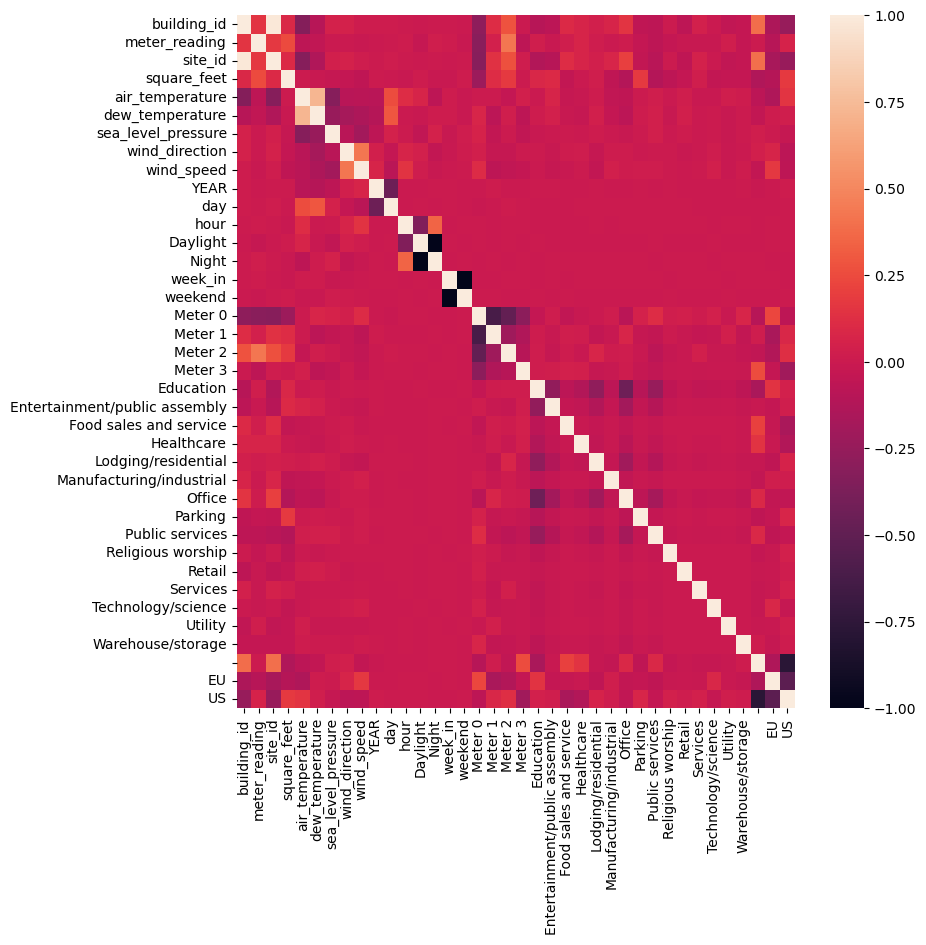

In [424]:
fig = plt.figure( figsize = (9,9))
sns.heatmap(merged_data.corr(),vmin = -1, vmax = 1)

# Restructuration des classes de bâtiments

In [417]:
for val in merged_data.loc[merged_data['sub_primary_use']==10]['building_id'].unique():
    print('i')
    sns.violinplot(merged_data.loc[merged_data['sub_primary_use']==1].loc[merged_data['building_id']==val], x = 'meter_reading')
    print(a)

recup infos stats sur la kde de la conso pour chaque immeuble, puis faire des clusters entre les sub_primary_use.

In [452]:
import scipy.signal as sg


In [478]:
merged_data['sub_primary_use'].unique()

array(['Office', 'Dormitory', 'College Classroom', 'Parking Garage',
       'Central Plant', 'Planetarium', 'Police Station',
       'Other - Recreation', 'Non-Refrigerated Warehouse', 'K-12 School',
       'Fire Station', 'College Laboratory', 'Parking: Enclosed Garage',
       'Student Union', 'Auditorium', 'Greenhouse', 'Park',
       'Residence Hall', 'Library', 'Conference Center',
       'Other - Lodging/Residential', 'Social/Meeting Hall', 'Academic',
       'Hospital', 'Maintenance Repair Shop', 'Technology/science',
       'Education', 'Entertainment/public assembly', 'Fitness Center',
       'Community Center, Community Centers', 'Research', 'Support',
       'Athletic', 'Patient Care', 'Primary/Secondary Classroom',
       'Museum', 'Other - Public Services', 'Retail', 'Public Service',
       'Sports Stadium', 'Health Services', 'Parking: Open Air Ramp',
       'Data Centre', 'Fire Station, Fire Stations',
       'Park, Community Centers', 'Office, Fire Stations',
       'R

In [488]:
merged_data['sub_primary_use'].value_counts()

Office                     207056
College Classroom          129125
Dormitory                   65974
College Laboratory          58020
Library                     39258
                            ...  
Data Centre                  1250
Warehouse                    1247
Park, Community Centers      1241
Office, Fire Stations        1182
Sports Facility                96
Name: sub_primary_use, Length: 73, dtype: int64

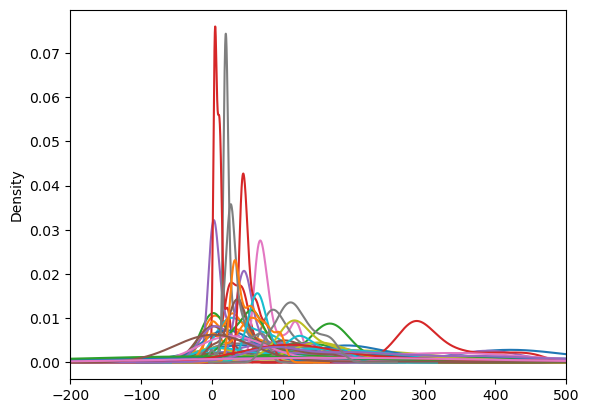

In [477]:
for val in ['College Classroom']:    
    for build_id in merged_data[merged_data['sub_primary_use']==val]['building_id'].unique():
        kde_energy = merged_data[merged_data['building_id']==build_id]['meter_reading'].plot.kde(xlim=(-200,500))
        line = kde_energy.lines[0]
        x, y = line.get_data()
        kde_energy = (x,y)
        kde_peaks = sg.find_peaks(y)
        (x[kde_peaks[0][0]],x[kde_peaks[0][1]])


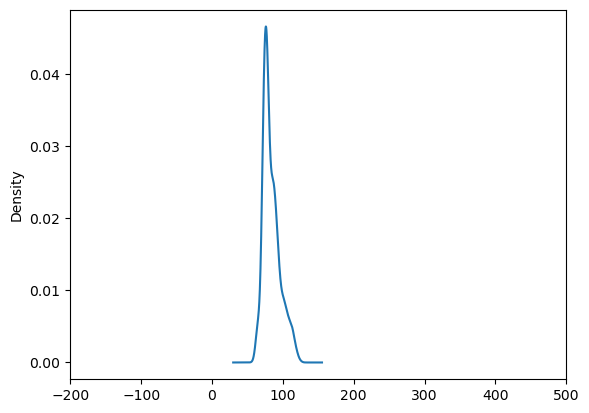

In [480]:
for val in ['Data Centre']:    
    for build_id in merged_data[merged_data['sub_primary_use']==val]['building_id'].unique():
        kde_energy = merged_data[merged_data['building_id']==build_id]['meter_reading'].plot.kde(xlim=(-200,500))
        line = kde_energy.lines[0]
        x, y = line.get_data()
        kde_energy = (x,y)
        kde_peaks = sg.find_peaks(y)
        #(x[kde_peaks[0][0]],x[kde_peaks[0][1]])

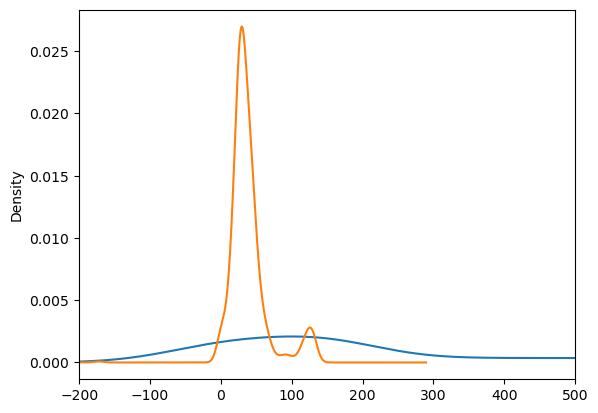

In [481]:
for val in ['Swimming Pool']:    
    for build_id in merged_data[merged_data['sub_primary_use']==val]['building_id'].unique():
        kde_energy = merged_data[merged_data['building_id']==build_id]['meter_reading'].plot.kde(xlim=(-200,500))
        line = kde_energy.lines[0]
        x, y = line.get_data()
        kde_energy = (x,y)
        kde_peaks = sg.find_peaks(y)
        #(x[kde_peaks[0][0]],x[kde_peaks[0][1]])

Méthode : apprentissage non supervisé pour trouver les données d'entrainement suffisamment proches pour lui donner les features de reading, puis on applique le regressors ?

# Premiers essais sans certaines données météos ni sub_use

In [283]:
try_data = merged_data.drop(['timestamp','sub_primary_use','sea_level_pressure','wind_direction','wind_speed'], axis = 1)

In [286]:
x_data = try_data.drop(['meter_reading'], axis = 1).to_numpy()
y_data = try_data['meter_reading'].to_numpy()

In [296]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

In [298]:
## Define Grid 
grid = { 
    'n_estimators': [10,30],
    'max_features': ['sqrt'],
    'max_depth' : [5,10],
    'random_state' : [18]
}
## show start time

## Grid Search function
CV_frf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_frf.fit(x_train, y_train)
## show end time


2022-10-26 22:56:50.135783


AttributeError: module 'datetime' has no attribute 'now'

In [301]:
pd.DataFrame(CV_frf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.592806,0.075301,0.071848,0.001860,5,sqrt,10,18,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.388683,0.389314,0.391498,0.395187,0.396271,0.392191,0.003056,3
1,10.033376,0.189197,0.166884,0.003367,5,sqrt,30,18,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.366811,0.363460,0.361546,0.364836,0.357898,0.362910,0.003040,4
2,5.973037,0.145829,0.118023,0.001097,10,sqrt,10,18,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.645709,0.671285,0.670397,0.655125,0.659072,0.660318,0.009631,1
3,18.863318,0.967432,0.332746,0.005919,10,sqrt,30,18,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.637457,0.662807,0.638173,0.638733,0.648697,0.645173,0.009730,2


In [ ]:
x_data = try_data.drop(['meter_reading',''], axis = 1).to_numpy()
y_data = try_data['meter_reading'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

In [ ]:
## Define Grid 
grid = { 
    'n_estimators': [10],
    'max_features': ['sqrt'],
    'max_depth' : [10],
    'random_state' : [18]
}
## show start time

## Grid Search function
CV_frf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_frf.fit(x_less_train, y_less_train)
## show end time


2022-10-26 22:56:50.135783


AttributeError: module 'datetime' has no attribute 'now'

In [ ]:
pd.DataFrame(CV_frf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.592806,0.075301,0.071848,0.001860,5,sqrt,10,18,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.388683,0.389314,0.391498,0.395187,0.396271,0.392191,0.003056,3
1,10.033376,0.189197,0.166884,0.003367,5,sqrt,30,18,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",0.366811,0.363460,0.361546,0.364836,0.357898,0.362910,0.003040,4
2,5.973037,0.145829,0.118023,0.001097,10,sqrt,10,18,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.645709,0.671285,0.670397,0.655125,0.659072,0.660318,0.009631,1
3,18.863318,0.967432,0.332746,0.005919,10,sqrt,30,18,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.637457,0.662807,0.638173,0.638733,0.648697,0.645173,0.009730,2


In [303]:
ypred = CV_frf.predict(x_test)
err = mean_absolute_percentage_error(y_test, ypred)

In [304]:
err

7.0308008789962216e+16

In [311]:
importances = CV_frf.best_estimator_.feature_importances_

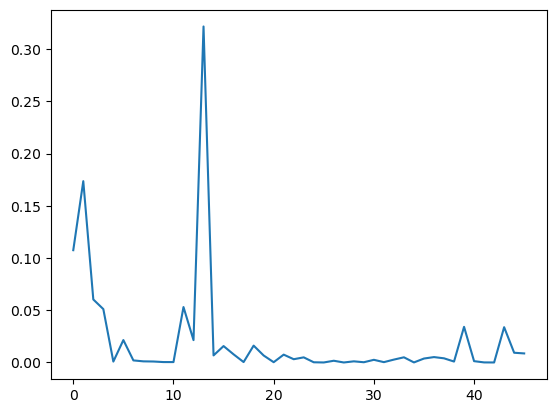

In [310]:
plt.plot(importances)

In [ ]:
try_data.drop(['meter_reading'], axis = 1).columns

Index([                  'building_id',                   'square_feet',
                     'air_temperature',               'dew_temperature',
                                'YEAR',                           'day',
                                'hour',                      'Daylight',
                               'Night',                       'week_in',
                             'weekend',                       'Meter 0',
                             'Meter 1',                       'Meter 2',
                             'Meter 3',                     'Education',
       'Entertainment/public assembly',        'Food sales and service',
                          'Healthcare',           'Lodging/residential',
            'Manufacturing/industrial',                        'Office',
                             'Parking',               'Public services',
                   'Religious worship',                        'Retail',
                            'Services',            

on va devoir classer autrement les secteurs par conso d'énergie. Le scope actuel n'est pas pertinent pour trouver de la valeur. Variance trop élevée au sein de ces groupes.

# Test d'un KNN

In [431]:
grid = { 
    'n_neighbors' : [2,3,4,5]
}

In [432]:


## Grid Search function
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=grid, cv= 5)
CV_knn.fit(x_train, y_train)
## show end time

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5]})

In [446]:
pd.DataFrame(CV_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.117293,0.008141,77.767121,1.778344,2,{'n_neighbors': 2},0.246632,0.256996,0.252501,0.248057,0.259500,0.252737,0.004962,4
1,0.123672,0.017068,79.325861,1.661221,3,{'n_neighbors': 3},0.329223,0.324570,0.331559,0.327747,0.330710,0.328762,0.002467,3
2,0.111227,0.006617,81.219466,1.811759,4,{'n_neighbors': 4},0.363818,0.358949,0.368162,0.365077,0.366447,0.364491,0.003124,2
3,0.115630,0.004761,80.532377,1.323089,5,{'n_neighbors': 5},0.380104,0.381112,0.386199,0.386823,0.383608,0.383570,0.002666,1


In [426]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)